# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Анализ данных

In [1]:
# импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from scipy.stats import chi2_contingency

from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import SCORERS
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
import catboost as cat
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
from warnings import filterwarnings
warnings.filterwarnings('error')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

RANDOM_STATE = 250722

In [2]:
# загрузка данных
try:
    contract = pd.read_csv(r'D:\\ЯП DS\\Final project\\contract.csv')
    personal = pd.read_csv(r'D:\\ЯП DS\\Final project\\personal.csv')
    internet = pd.read_csv(r'D:\\ЯП DS\\Final project\\internet.csv')
    phone = pd.read_csv(r'D:\\ЯП DS\\Final project\\phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
# функция на первичную проверку данных
def df_check(dataset):
    print('Общая информация\n')
    display(dataset.info())
    print('Первые строки датасета\n')
    display(dataset.head())
    print('Описательная статистика\n')
    display(dataset.describe())
    print('Описательная статистика категориальных признаков\n')
    display(dataset.describe(include=['object', 'bool']))
    print('Количество пропусков в каждом столбце\n')
    display(dataset.isna().sum())
    print('Количество уникальных значений\n')
    display(dataset.nunique())
    print('Количество дубликатов\n')
    display(dataset.duplicated().sum())

In [4]:
df_check(contract)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Первые строки датасета



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Описательная статистика



,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Описательная статистика категориальных признаков



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,5,3,2,4,6531
top,7852-LECYP,2014-02-01,No,Month-to-month,Yes,Electronic check,20.2
freq,1,366,5174,3875,4171,2365,11


Количество пропусков в каждом столбце



customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Количество уникальных значений



customerID          7043
BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
dtype: int64

Количество дубликатов



0

In [5]:
df_check(personal)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Первые строки датасета



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Описательная статистика



,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Описательная статистика категориальных признаков



,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7852-LECYP,Male,No,No
freq,1,3555,3641,4933


Количество пропусков в каждом столбце



customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Количество уникальных значений



customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64

Количество дубликатов



0

In [6]:
df_check(internet)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Первые строки датасета



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Описательная статистика



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0840-DCNZE,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Описательная статистика категориальных признаков



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0840-DCNZE,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество пропусков в каждом столбце



customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Количество уникальных значений



customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64

Количество дубликатов



0

In [7]:
df_check(phone)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Первые строки датасета



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Описательная статистика



,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2434-EEVDB,No
freq,1,3390


Описательная статистика категориальных признаков



,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2434-EEVDB,No
freq,1,3390


Количество пропусков в каждом столбце



customerID       0
MultipleLines    0
dtype: int64

Количество уникальных значений



customerID       6361
MultipleLines       2
dtype: int64

Количество дубликатов



0

- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – электронный документ об оплате,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

После первичного анализа данных мной было выявлено, что некоторые столбцы ('PaperlessBilling', 'Partner','Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','MultipleLines') имеют бинарные данные, а их соответственно надо заменить с Yes и No на 1 и 0.


In [8]:
# функция будет возвращать 1 при признаке 'Yes' и 0 при признаке 'No'
def one_zero(binar):
    if binar == 'Yes':
        return 1
    elif binar == 'No':
        return 0

In [9]:
# подготовлю данные
column_binar = ['PaperlessBilling', 'Partner','Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
            'StreamingTV', 'StreamingMovies','MultipleLines']

table_list = [contract, personal, internet, phone]

In [10]:
for col in column_binar:
    for table in table_list:
        if col in table.columns:
            table[col] = table[col].apply(one_zero)

In [11]:
for table in table_list:
    display(table.head(3))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0


,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0


Ну вроде как сформировалось первичное представление о данных.

Итак, вырисовывается следующая картина:
1. Всего пользователей, с которыми было заключено контрактов - 7043 (все значения уникальны).
2. Не каждый клиент пользуется сразу двумя основными услугами: 5517 пользователей интернета, 6361 телефонии.
3. Пропуски и дубликаты во всех таблицах отсутствуют.
4. У столбцов BeginDate	всего 77 уникальных значений, а у EndDate всего 5.
5. У EndDate значение типа даты отличается от BeginDate.

Для данных числовым значением и с категориальным сделаю списки

In [12]:
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'TotalDays']
categorial_columns = ['Type','PaymentMethod','gender','SeniorCitizen','InternetService']

В ходе вопросов и ответов с тимлидом как я понял EndDate не является целевым признаком, однако именно от него идёт выявление целевого признака. Добавлю столбец Churn (отток клиентов), который будет означать уход клиента. Если значение в столбце EndDate равно "No", то значит клиент не ушел и в столбце Churn (целевой признак) равен 0. Если дата ухода есть, то целевой признак равен 1.

In [13]:
contract['Churn'] = contract.apply(lambda x: 0 if x.EndDate == 'No' else 1, axis=1)

In [14]:
# в EndDate значения No означают, что клиент не ушёл, но предоставленные данные актуальны до 1 февраля 2020
# для корректной обработки заменю все значения "No" в EndDate на дату последнего заполнения.

contract['EndDate'] = contract['EndDate'].replace(['No'], ['2020-02-01'])
print(contract[contract['EndDate'] == 'No'].shape[0])

0


Всё ок. Теперь скорректирую и переведу EndDate и BeginDate в формат даты

In [15]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

В таблице contract столбец TotalCharges – всего потрачено денег на услуги почему-то имеет тип данных object

In [16]:
contract['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [17]:
contract['TotalCharges'].unique().min()

' '

ого, есть пробелы, интересно, что за ними? отсортирую и проверю

In [18]:
contract.loc[contract.loc[:, 'TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,0,Mailed check,73.35,,0


У всех пользователей со значением пробел в TotalCharges BeginDate стоит 1 февраля 2020. Смею предположить, что люди подключились и ещё не успели оплатить, значит логично будет пробелы заменить на 0.


In [19]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', 0)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

Считаю, что полезным будет добавить ещё один столбец, в котором будет отображено количество дней пользования услугами (жизнь клиента).


In [20]:
contract['TotalDays'] = (contract['EndDate'] - contract['BeginDate']).dt.days
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 550.4+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,61


In [21]:
# объединю все таблицы в одну

full_churn = contract \
    .merge(personal, how='left', on='customerID') \
    .merge(internet, how='left', on='customerID') \
    .merge(phone, how='left', on='customerID') 

In [22]:
# проверю объединение по уникальности customerID
full_churn['customerID'].is_unique

True

In [23]:
# проверю полученную таблицу
df_check(full_churn)

Общая информация

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   int64         
 13  Dependents        7043 non-null   int64         
 14  Intern

None

Первые строки датасета



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,31,...,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,0,1036,...,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,61,...,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371,...,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,61,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Описательная статистика



,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,TotalDays,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,6361.000000
mean,0.592219,64.761692,2279.734304,0.265370,985.996166,0.162147,0.483033,0.299588,0.365960,0.440276,0.439007,0.370491,0.490665,0.495197,0.467065
std,0.491457,30.090047,2266.794470,0.441561,747.587844,0.368612,0.499748,0.458110,0.481742,0.496465,0.496311,0.482980,0.499958,0.500022,0.498953
min,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,398.550000,0.000000,273.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,70.350000,1394.550000,0.000000,883.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,89.850000,3786.600000,1.000000,1676.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,118.750000,8684.800000,1.000000,2191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Описательная статистика категориальных признаков



,customerID,Type,PaymentMethod,gender,InternetService
count,7043,7043,7043,7043,5517
unique,7043,3,4,2,2
top,7852-LECYP,Month-to-month,Electronic check,Male,Fiber optic
freq,1,3875,2365,3555,3096


Количество пропусков в каждом столбце



customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
TotalDays              0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Количество уникальных значений



customerID          7043
BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
TotalDays            156
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
MultipleLines          2
dtype: int64

Количество дубликатов



0

Пропуски в InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines скорее всего означают, что услуги не подключены. Заменю пропуски на 0.

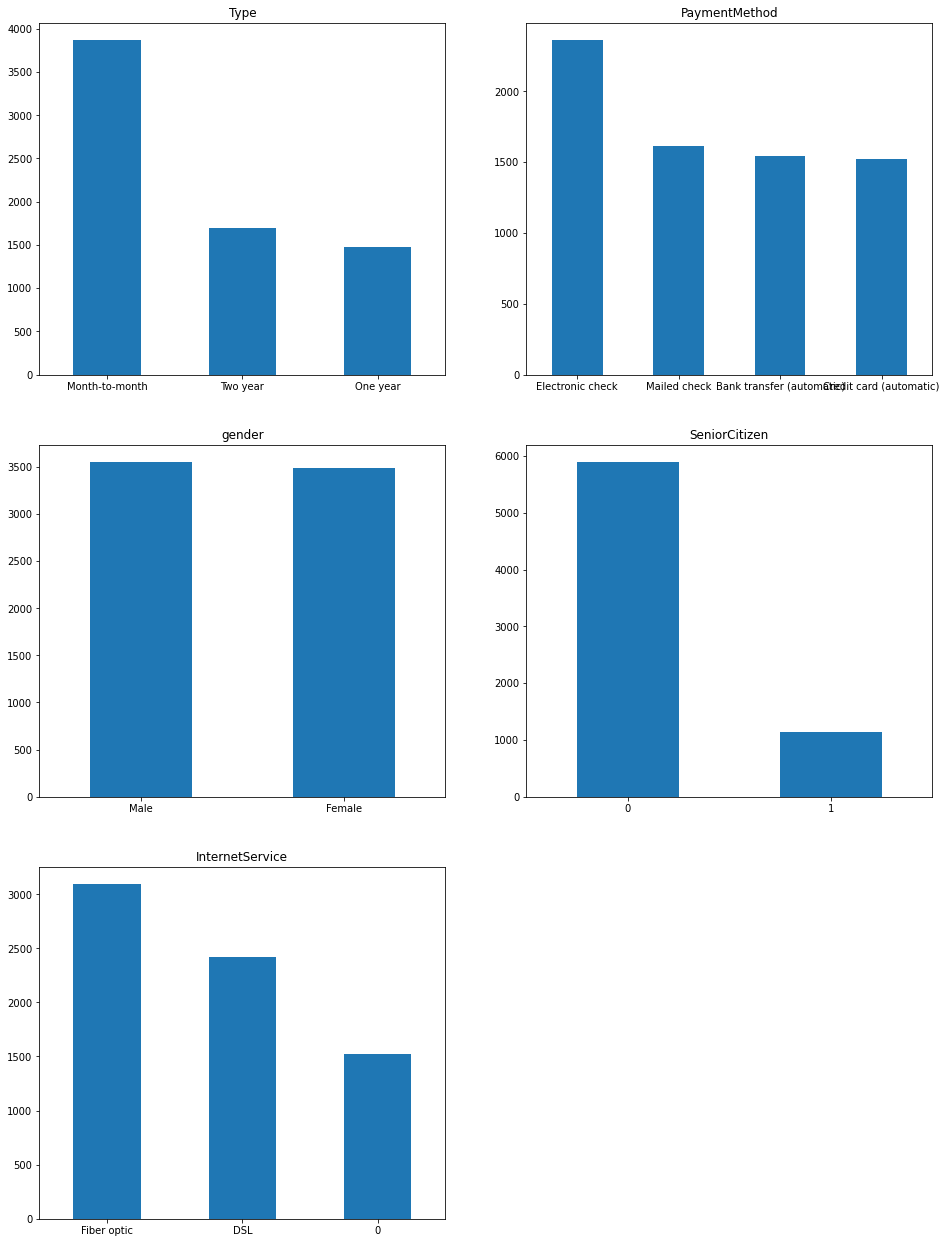

In [24]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    full_churn[column] = full_churn[column].fillna(0)

cols = 2
rows = 3

plt.figure(figsize=(16, 22))

for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    full_churn[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
    )
        
plt.show()

Для того, чтобы выявить как признаки влияют на целевой признак буду использовать статистическую значимость. Для этого сформулирую нулевую гипотезу:
- H0: признак не связан с оттоком клиентов;
- альтернативная же будет H1: признак связан с оттоком клиентов.

Значение порога статистической значимости приму как alpha = 0.05.

In [25]:
alpha = 0.05

Создам функцию, которая принимает на вход столбец, по которому нужна группировка. Функция будет строить таблицу с количеством ушедших и оставшихся клиентов, сгруппированных по нужному признаку, вычислять значение статистики и делать вывод о влиянии признака на уход клиента из компании.

In [26]:
def table_for_chi2(col_group):
    table1 = full_churn.groupby(col_group, as_index=False)['Churn'].sum()
    table2 = full_churn.groupby(col_group, as_index=False)['customerID'].count()
    merge = table1.merge(table2, on=col_group)
    merge.rename(columns = {'customerID':'all'}, inplace = True)
    merge['notChurn'] = merge['all'] - merge['Churn']
    merge = merge.drop('all', axis=1)
        
    stat, p, dof, expected = chi2_contingency(merge[['Churn', 'notChurn']])
      
    return merge, p

,Type,Churn,notChurn
0,Month-to-month,1655,2220
1,One year,166,1307
2,Two year,48,1647


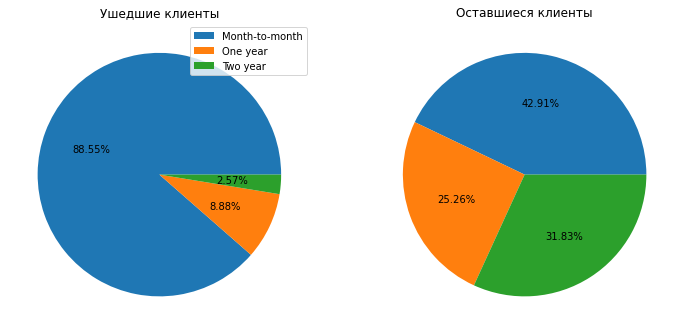

p-значение: 5.863038300672725e-258
Отклонить нулевую гипотезу


,PaperlessBilling,Churn,notChurn
0,0,469,2403
1,1,1400,2771


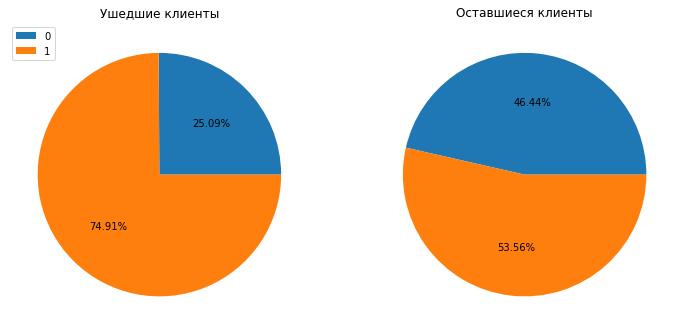

p-значение: 4.073354668665985e-58
Отклонить нулевую гипотезу


,PaymentMethod,Churn,notChurn
0,Bank transfer (automatic),258,1286
1,Credit card (automatic),232,1290
2,Electronic check,1071,1294
3,Mailed check,308,1304


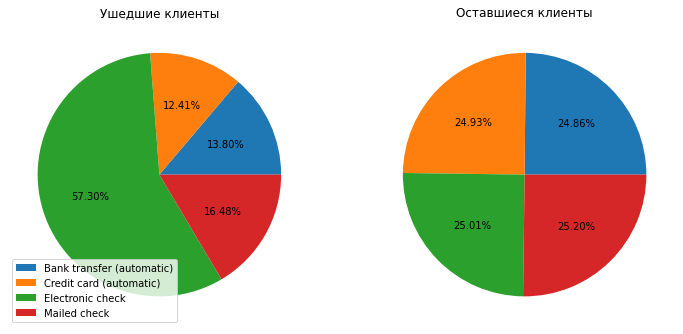

p-значение: 3.6823546520097993e-140
Отклонить нулевую гипотезу


,gender,Churn,notChurn
0,Female,939,2549
1,Male,930,2625


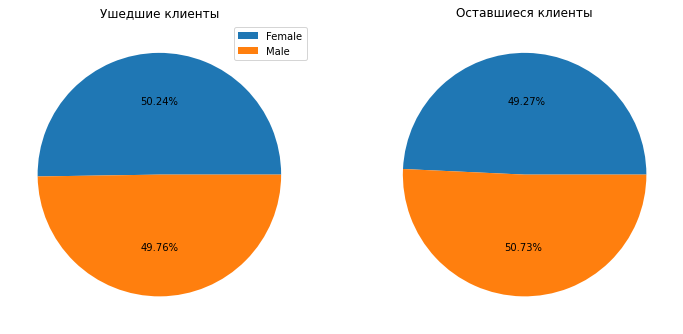

p-значение: 0.48657873605618596
Не удалось отклонить нулевую гипотезу


,SeniorCitizen,Churn,notChurn
0,0,1393,4508
1,1,476,666


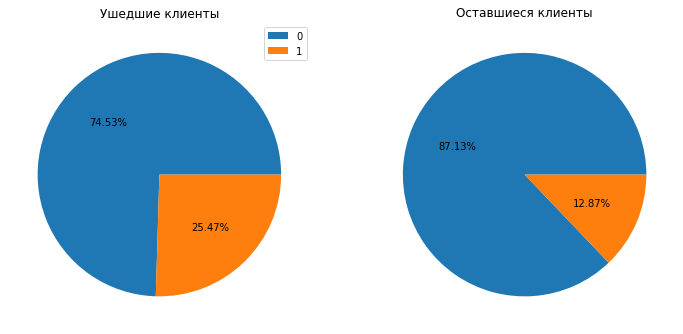

p-значение: 1.510066805092378e-36
Отклонить нулевую гипотезу


,Partner,Churn,notChurn
0,0,1200,2441
1,1,669,2733


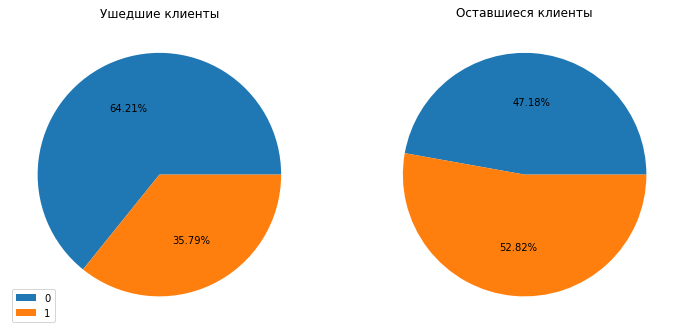

p-значение: 2.1399113440759935e-36
Отклонить нулевую гипотезу


,Dependents,Churn,notChurn
0,0,1543,3390
1,1,326,1784


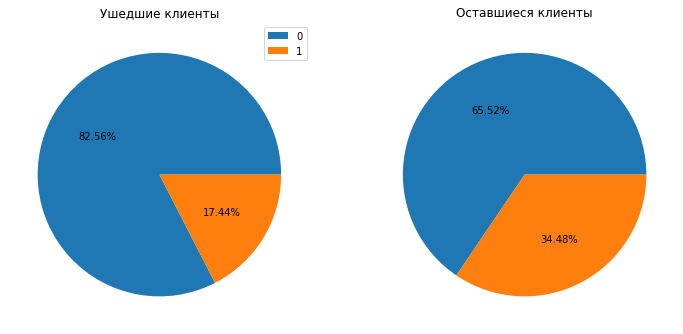

p-значение: 4.924921661215491e-43
Отклонить нулевую гипотезу


,InternetService,Churn,notChurn
0,0,113,1413
1,DSL,459,1962
2,Fiber optic,1297,1799


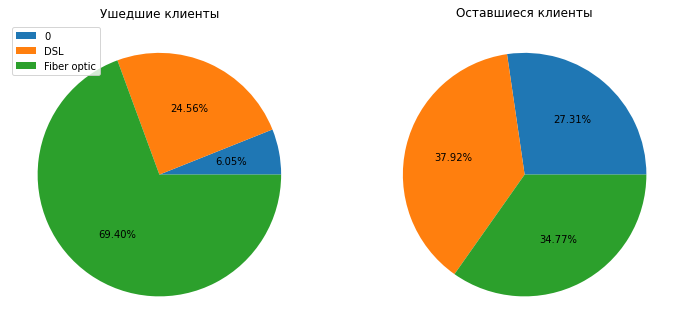

p-значение: 9.571788222840544e-160
Отклонить нулевую гипотезу


,OnlineSecurity,Churn,notChurn
0,0.0,1574,3450
1,1.0,295,1724


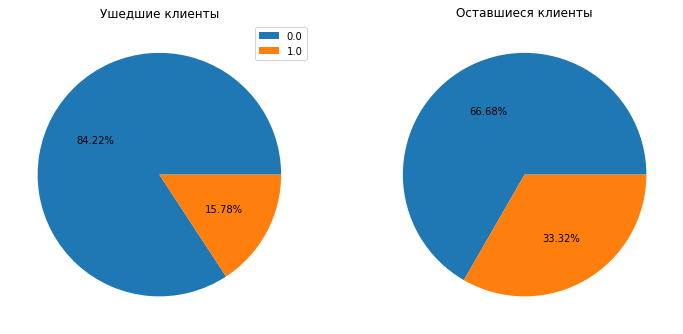

p-значение: 1.2320984831180024e-46
Отклонить нулевую гипотезу


,OnlineBackup,Churn,notChurn
0,0.0,1346,3268
1,1.0,523,1906


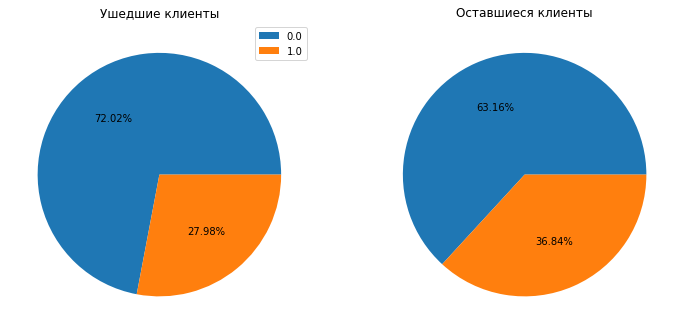

p-значение: 6.214092807254797e-12
Отклонить нулевую гипотезу


,DeviceProtection,Churn,notChurn
0,0.0,1324,3297
1,1.0,545,1877


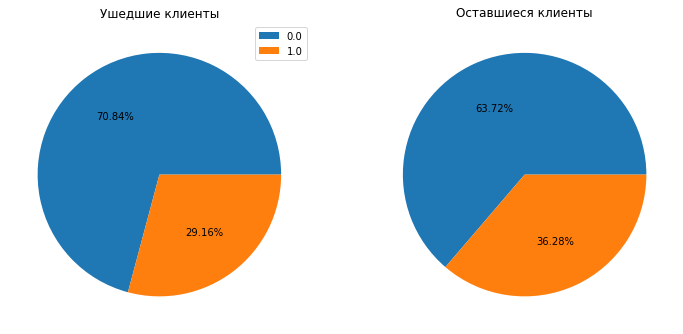

p-значение: 3.315693222362861e-08
Отклонить нулевую гипотезу


,TechSupport,Churn,notChurn
0,0.0,1559,3440
1,1.0,310,1734


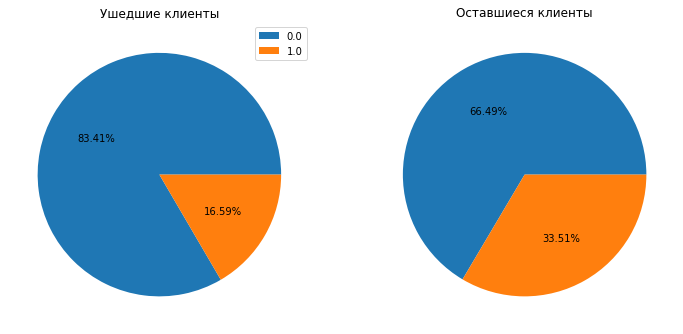

p-значение: 2.9235674453141176e-43
Отклонить нулевую гипотезу


,StreamingTV,Churn,notChurn
0,0.0,1055,3281
1,1.0,814,1893


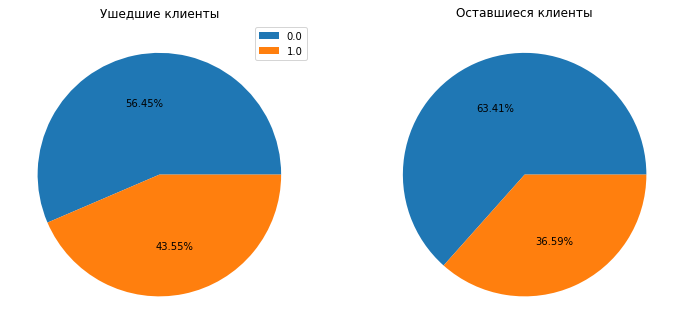

p-значение: 1.3024835736732676e-07
Отклонить нулевую гипотезу


,StreamingMovies,Churn,notChurn
0,0.0,1051,3260
1,1.0,818,1914


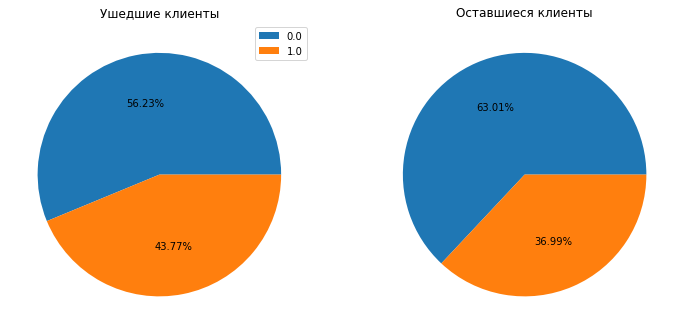

p-значение: 2.9974738476267514e-07
Отклонить нулевую гипотезу


,MultipleLines,Churn,notChurn
0,0.0,1019,3053
1,1.0,850,2121


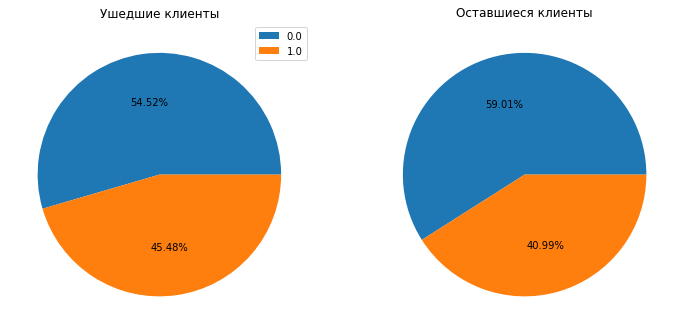

p-значение: 0.0008433795342472428
Отклонить нулевую гипотезу


In [27]:
# вызову функцию для всех категориальных значений

categorials_columns = ['Type','PaperlessBilling','PaymentMethod','gender','SeniorCitizen','Partner','Dependents','InternetService', 
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in categorials_columns:
    table_chi2, p_chi2 = table_for_chi2(col)
    display(table_chi2)
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    plt.pie(table_chi2['Churn'], autopct='%1.2f%%')
    plt.legend(labels=table_chi2[col], loc='best')
    plt.title('Ушедшие клиенты')
   
    
    plt.subplot(1, 2, 2)
    plt.pie(table_chi2['notChurn'], autopct='%1.2f%%')
    plt.title('Оставшиеся клиенты')
    plt.show()
    print('p-значение:', p_chi2)
    if p_chi2 < alpha:
        print('Отклонить нулевую гипотезу')
    else:
        print('Не удалось отклонить нулевую гипотезу')

Интересная картина получается: все категориальные признаки, кроме gender, так или иначе влияют на целевой признак (отток клиентов). Значит для модели будет важно использовать их всех, кроме gender - его я удалю, так как он не информативен для модели.

Сейчас можно подвести первичный вывод по анализу категориальных признаков:
1. Самый популярный способ оплаты - помесячный
2. Чаще происходит оплата через электронный чек
3. Оптоволокно популярнее.
4. Пенсионеров среди клиентов не так много, но зато они чаще расторгают договор.
5. Доля отказов среди тех, кто использует помесячную оплату выше, чем среди тех, кто сразу платит вперёд.
6. Дополнительные услуги слабо влияют на отказы
7. Если пользователь не пользуется интернетом, то вероятность отказа ниже.   

Теперь посмотрю как дела обстоят для количественых признаков. Проверю на диаграмме размаха и распределение значений.

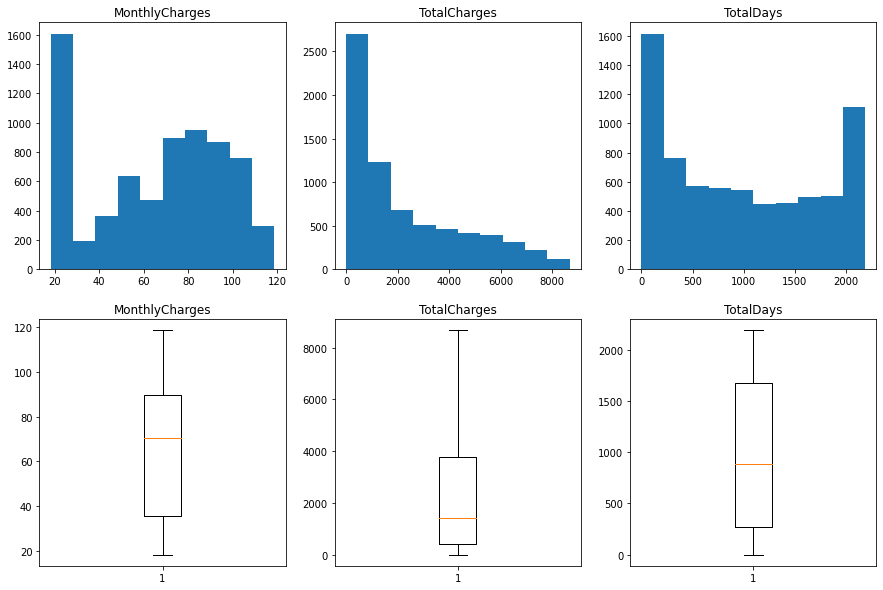

In [28]:
cols = 3
rows = 2

plt.figure(figsize=(15, 10))

idx = 0
for column in numeric_columns:
    idx += 1 
    
    plt.subplot(rows, cols, idx)
    plt.hist(full_churn[column])
    plt.title(column)
    
for column in numeric_columns:
    idx += 1 
    
    plt.subplot(rows, cols, idx)
    plt.boxplot(full_churn[column])
    plt.title(column)
        
plt.show()

In [29]:
display(full_churn[numeric_columns].describe())

,MonthlyCharges,TotalCharges,TotalDays
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,985.996166
std,30.090047,2266.794470,747.587844
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,273.000000
50%,70.350000,1394.550000,883.000000
75%,89.850000,3786.600000,1676.000000
max,118.750000,8684.800000,2191.000000


Наглядно проверю как распределены ежемесячные платежи, а то на предыдущем графике заметны подозрительные аномалии - смещение к нулю.

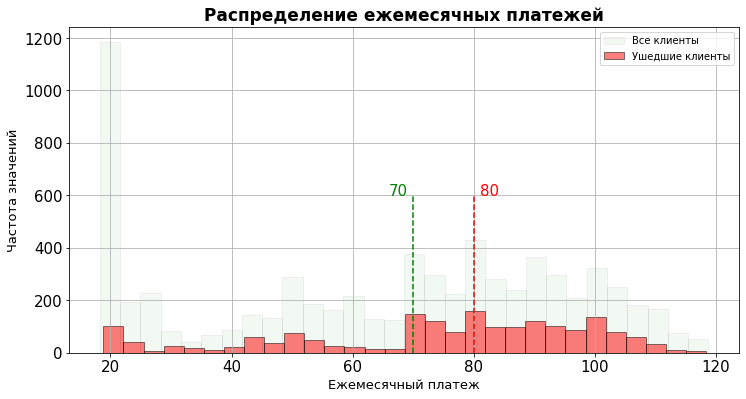

In [30]:
ax = full_churn.plot(kind='hist', y='MonthlyCharges', ec='black', bins=30, 
                              linewidth=1, alpha=alpha, label='Все клиенты', color='g')
full_churn[(full_churn['Churn']==1)].plot(kind='hist', y='MonthlyCharges', ec='black', bins=30,linewidth=1, alpha=0.5, 
                         label='Ушедшие клиенты', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='r')
ax.vlines(70, 0, 600, color= 'g', linestyle ='--',)
ax.vlines(80, 0, 600, color= 'r', linestyle ='--',)
ax.text(81, 600, '80', fontsize=15, color='r')
ax.text(66, 600, '70', fontsize=15, color='g')
ax.set_ylabel('Частота значений', fontsize=13)
ax.set_xlabel('Ежемесячный платеж', fontsize=13)
ax.set_title('Распределение ежемесячных платежей', fontsize=17, fontweight='bold')
plt.show()

Пока нельзя делать однозначные выводы, но заметно, что среди ушедших клиентов больше всего тех, у кого ежемесячный платеж был в интервале от 70 до 110. Среди всех клиентов очень много тех, кто платит в месяц 20. Из этого можно заключить, что большой размер ежемесячного платежа повышает вероятность того, что клиент уйдет (логично).
Также на графике видно, что клиентов с ежемесячным платежом в 20 уходило больше, чем клиентов с ежемесячным платежом, например, в 60. Т.е. тут есть еще факторы, влияющие на уход клиента.

In [31]:
# какой интеренет был у ушедших клиентов
full_churn.query('75 < MonthlyCharges < 100 and Churn == 1')['InternetService'].value_counts().to_frame()

,InternetService
Fiber optic,805
DSL,19


Видимо оптоволокно дорогое удовольствие в компании.

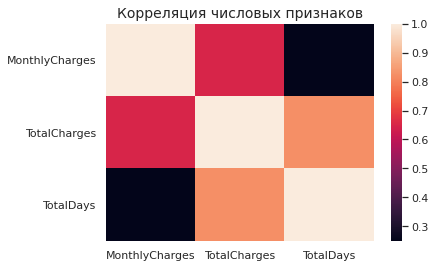

In [32]:
# посмотрю на корреляцию числовых признаков

sns.set(font_scale=1)
sns.heatmap(full_churn[numeric_columns].corr())
plt.title('Корреляция числовых признаков', fontsize=14)

plt.show()

Видно, что сильная корреляция наблюдается между признакаями TotalDays и TotalCharges. Monthlycharges и TotalCharges скоррелированы довольно средне. Посмотрю что на диаграммах рассеяния.

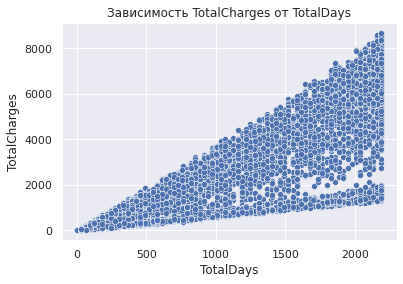

In [33]:
sns.scatterplot(data=full_churn, x="TotalDays", y="TotalCharges")
plt.title('Зависимость TotalCharges от TotalDays')
plt.show()

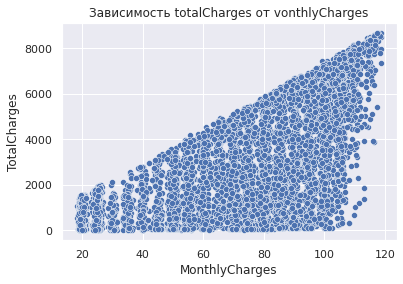

In [34]:
sns.scatterplot(data=full_churn, x="MonthlyCharges", y="TotalCharges")
plt.title('Зависимость totalCharges от vonthlyCharges')
plt.show()

Наблюдается сильная линейная зависимость TotalCharges от TotalDays.

Выводы по количественным признакам:
- Значения в столбце TotalCharges убывают, в то же время в столбце MonthlyCharges заметен пик в районе 85 - видимо пользователи, которые платят за тариф много на долго не остаются.
- Также у MonthlyCharges виден пик в районе 20, что является минимальным значением
- В столбце TotalDays видно 2 пика - в районе новых клиентов и лояльных, которые долго пользуются услугами
- Аномальных выбросов не обнаружил

### Выводы по анализу

In [35]:
# сделаю копию и буду работать с ней
full_churn_backup = full_churn.copy()

Удалю следующие признаки из датафрейма:

- customerID - уникальный идентификатор пользователя, "шум" для модели;

- TotalCharges - удалю, т.к. сильная корреляции с количеством месяцев пользования услугами;

- BeginDate - удалю как фактор времени и чтобы избежать утечку данных;

- EndDate - удалю как фактор времени;

- gender - после проверки гипотезы о статистической значимости.

In [36]:
full_churn_new = full_churn_backup.drop(['customerID', 'TotalCharges', 'BeginDate','EndDate','gender'], axis=1)

In [37]:
full_churn_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   Churn             7043 non-null   int64  
 5   TotalDays         7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   int64  
 8   Dependents        7043 non-null   int64  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   float64
 11  OnlineBackup      7043 non-null   float64
 12  DeviceProtection  7043 non-null   float64
 13  TechSupport       7043 non-null   float64
 14  StreamingTV       7043 non-null   float64
 15  StreamingMovies   7043 non-null   float64
 16  MultipleLines     7043 non-null   float64


In [38]:
# остальные переменные закодирую техникой OHE (OneHotEncoder)

full_churn_new = pd.get_dummies(full_churn_new, columns = ['Type', 'InternetService','PaymentMethod'], drop_first = True)

In [39]:
full_churn_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PaperlessBilling                       7043 non-null   int64  
 1   MonthlyCharges                         7043 non-null   float64
 2   Churn                                  7043 non-null   int64  
 3   TotalDays                              7043 non-null   int64  
 4   SeniorCitizen                          7043 non-null   int64  
 5   Partner                                7043 non-null   int64  
 6   Dependents                             7043 non-null   int64  
 7   OnlineSecurity                         7043 non-null   float64
 8   OnlineBackup                           7043 non-null   float64
 9   DeviceProtection                       7043 non-null   float64
 10  TechSupport                            7043 non-null   float64
 11  Stre

In [40]:
full_churn_new 

,PaperlessBilling,MonthlyCharges,Churn,TotalDays,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,0,31,0,1,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0,0,1,0,0,1,0
1,0,56.95,0,1036,0,0,0,1.0,0.0,1.0,...,0.0,0.0,0.0,1,0,1,0,0,0,1
2,1,53.85,1,61,0,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0,0,1,0,0,0,1
3,0,42.30,0,1371,0,0,0,1.0,0.0,1.0,...,0.0,0.0,0.0,1,0,1,0,0,0,0
4,1,70.70,1,61,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,84.80,0,730,0,1,1,1.0,0.0,1.0,...,1.0,1.0,1.0,1,0,1,0,0,0,1
7039,1,103.20,0,2191,0,1,1,0.0,1.0,1.0,...,1.0,1.0,1.0,1,0,0,1,1,0,0
7040,1,29.60,0,337,0,1,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0,0,1,0,0,1,0
7041,1,74.40,1,123,1,1,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0,0,0,1,0,0,1


## Обучение моделей

Исходный набор данных поделю на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов сделаю 60% / 20% / 20%

In [41]:
target = full_churn_new['Churn']
features = full_churn_new.drop('Churn', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=RANDOM_STATE, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                              random_state=RANDOM_STATE, stratify=target_valid)
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(4225, 20) (1409, 20) (1409, 20)
(4225,) (1409,) (1409,)


### Модель RandomForestClassifier

In [43]:
%%time
RFC = RandomForestClassifier(class_weight = 'balanced', random_state = RANDOM_STATE)

RFC.fit(features_train, target_train)

RFC_Prediction_Proba = RFC.predict_proba(features_train)[:,1]
RFC_Predictions = RFC.predict(features_train)

RFC_roc = roc_auc_score(target_train, RFC_Prediction_Proba)
RFC_acc = accuracy_score(target_train, RFC_Predictions)
print('roc_auc =', RFC_roc)
print('RFC_acc =', RFC_acc)

roc_auc = 0.9999895102403046
RFC_acc = 0.9985798816568048
CPU times: user 447 ms, sys: 8.06 ms, total: 456 ms
Wall time: 455 ms


Feature importances:
 1. feature 'TotalDays' (0.2596)
 2. feature 'MonthlyCharges' (0.2186)
 3. feature 'Type_Two year' (0.0799)
 4. feature 'InternetService_Fiber optic' (0.0530)
 5. feature 'PaymentMethod_Electronic check' (0.0417)
 6. feature 'Type_One year' (0.0403)
 7. feature 'PaperlessBilling' (0.0294)
 8. feature 'OnlineSecurity' (0.0270)
 9. feature 'Partner' (0.0259)
10. feature 'OnlineBackup' (0.0242)
11. feature 'TechSupport' (0.0237)
12. feature 'Dependents' (0.0234)
13. feature 'SeniorCitizen' (0.0222)
14. feature 'MultipleLines' (0.0221)
15. feature 'StreamingMovies' (0.0212)
16. feature 'StreamingTV' (0.0208)
17. feature 'DeviceProtection' (0.0207)
18. feature 'PaymentMethod_Credit card (automatic)' (0.0170)
19. feature 'InternetService_DSL' (0.0156)
20. feature 'PaymentMethod_Mailed check' (0.0136)


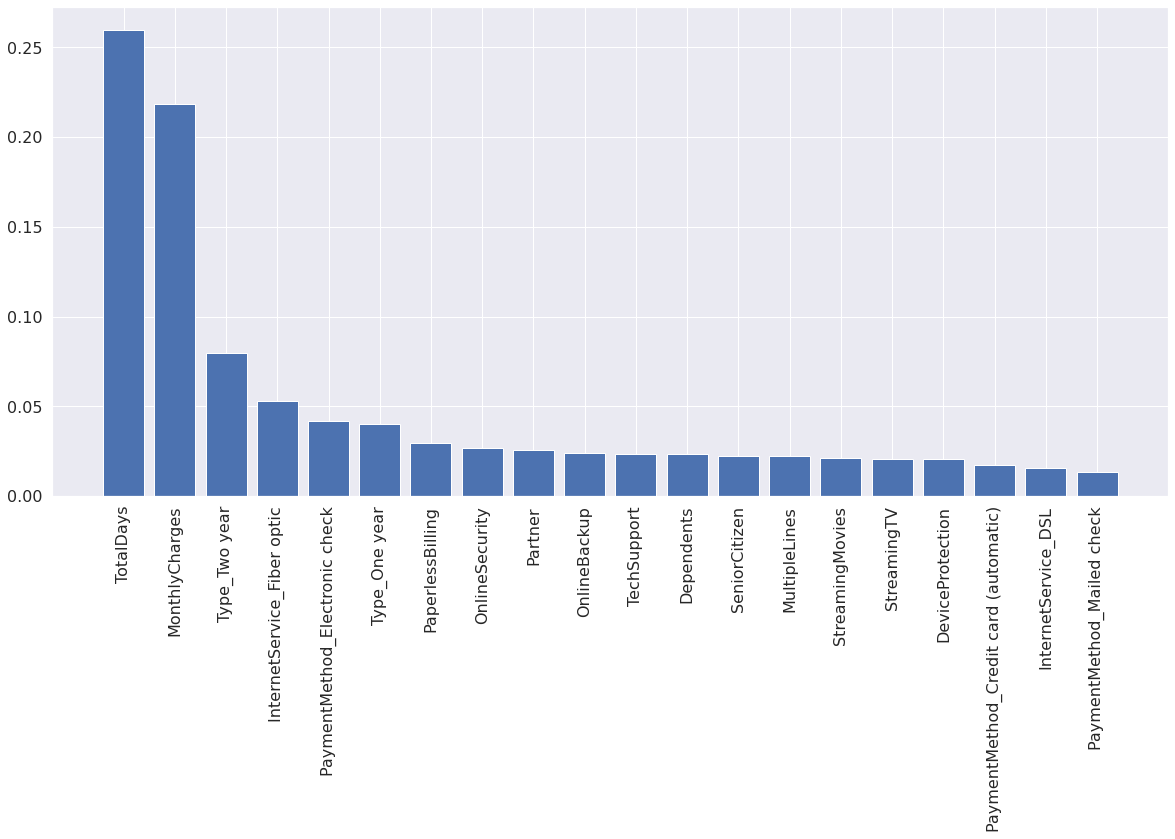

In [44]:
# исследую признаки

feature_import2 = RFC.feature_importances_
col_names = features_train.columns
indices = np.argsort(feature_import2)[::-1]
print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, col_names[idx], feature_import2[idx]))
d1 = pd.Series(data=feature_import2, index =col_names  ).sort_values(ascending=False)
plt.figure(figsize=(20,9))
plt.bar(d1.index,d1.values)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=90);

In [45]:
feature_importances = d1.iloc[:15].index
feature_importances

Index(['TotalDays', 'MonthlyCharges', 'Type_Two year',
       'InternetService_Fiber optic', 'PaymentMethod_Electronic check',
       'Type_One year', 'PaperlessBilling', 'OnlineSecurity', 'Partner',
       'OnlineBackup', 'TechSupport', 'Dependents', 'SeniorCitizen',
       'MultipleLines', 'StreamingMovies'],
      dtype='object')

## Модель RandomForestClassifier с FI и CV

In [46]:
rfc_X_train = features_train[feature_importances]
rfc_X_test = features_test[feature_importances]

In [47]:
RFC_2_fi_CV = GridSearchCV(RandomForestClassifier(criterion = 'entropy', class_weight='balanced'),{
                            'max_depth': range(3,15,3),
                            'n_estimators': range(10,100, 10),
                            'min_samples_split' : range(4,28,4),
                            'min_samples_leaf' : range(3,13,2)},
                             cv = 5,
                             scoring = 'roc_auc',
                              n_jobs=-1)

In [48]:
%%time
RFC_2_fi_CV.fit(rfc_X_train, target_train)

CPU times: user 9min 35s, sys: 3.41 s, total: 9min 39s
Wall time: 9min 39s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy'),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 15, 3),
                         'min_samples_leaf': range(3, 13, 2),
                         'min_samples_split': range(4, 28, 4),
                         'n_estimators': range(10, 100, 10)},
             scoring='roc_auc')

In [49]:
# произведу подбор лучших параметров
best_params_RFC_2_fi_CV = RFC_2_fi_CV.best_params_
print('best_params_RFC_2_fi_CV =', best_params_RFC_2_fi_CV)

best_params_RFC_2_fi_CV = {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 24, 'n_estimators': 70}


In [50]:
RFC_2_fi_CV.best_score_

0.8587211430575035

In [51]:
%%time
RFC_2_fi_CV = RandomForestClassifier(**best_params_RFC_2_fi_CV, random_state = RANDOM_STATE)

RFC_2_fi_CV.fit(rfc_X_train, target_train)

RFC_2_fi_CV_Prediction_Proba = RFC_2_fi_CV.predict_proba(rfc_X_train)[:,1]
RFC_2_fi_CV_Predictions = RFC_2_fi_CV.predict(rfc_X_train)


RFC_2_fi_CV_roc = roc_auc_score(target_train, RFC_2_fi_CV_Prediction_Proba)
RFC_2_fi_CV_acc = accuracy_score(target_train, RFC_2_fi_CV_Predictions)
print('RFC_2_fi_CV_roc =', RFC_2_fi_CV_roc)
print('RFC_2_fi_CV_acc =', RFC_2_fi_CV_acc)

RFC_2_fi_CV_roc = 0.906324003099221
RFC_2_fi_CV_acc = 0.8373964497041421
CPU times: user 248 ms, sys: 4 µs, total: 248 ms
Wall time: 250 ms


### Модель CatBoostClassifier

In [52]:
train_dataset = Pool(features_train, target_train)
test_dataset = Pool(features_test, target_test)

In [53]:
%%time
CB = CatBoostClassifier(loss_function = 'CrossEntropy', learning_rate = 0.03, random_state = RANDOM_STATE)
CB.fit(train_dataset, plot=True, verbose = False)
CB_Prediction_Proba = CB.predict_proba(features_train)[:,1]
CB_Prediction = CB.predict(features_train)
CB_roc = roc_auc_score(target_train, CB_Prediction_Proba)
CB_acc = accuracy_score(target_train, CB_Prediction)
print('CB_roc =', CB_roc)
print('CB_acc =', CB_acc)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CB_roc = 0.9830198092645559
CB_acc = 0.9370414201183432
CPU times: user 1.96 s, sys: 96 ms, total: 2.06 s
Wall time: 2.87 s


,Feature Id,Importances
0,TotalDays,48.175863
1,MonthlyCharges,14.149145
2,Type_Two year,5.553630
3,InternetService_Fiber optic,3.196299
4,Type_One year,3.007108
5,PaymentMethod_Electronic check,2.852667
6,PaperlessBilling,2.809673
7,Dependents,2.078233
8,TechSupport,2.073793
9,MultipleLines,1.735290


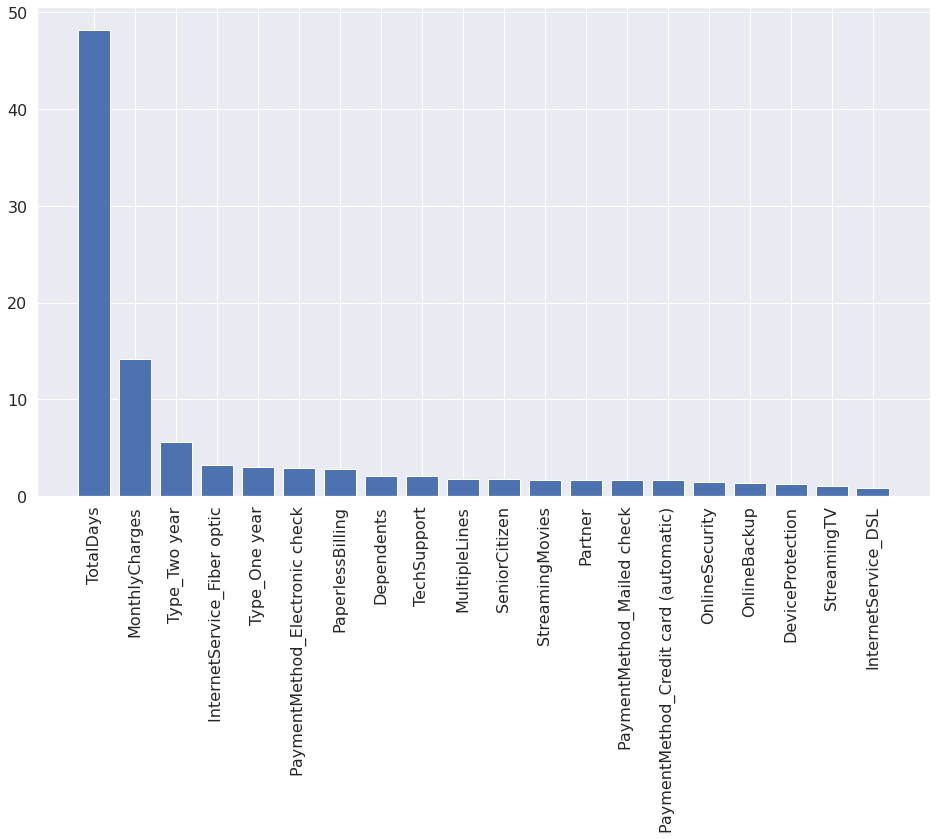

In [54]:
# исследую признаки

feature_import = CB.get_feature_importance(train_dataset, prettified = True)
plt.figure(figsize=(16,9))
plt.bar(feature_import['Feature Id'],feature_import['Importances'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=90);
feature_import

In [55]:
CB_features = feature_import.set_index('Feature Id').query('Importances > 1.5')
CB_features

,Importances
Feature Id,
TotalDays,48.175863
MonthlyCharges,14.149145
Type_Two year,5.553630
InternetService_Fiber optic,3.196299
Type_One year,3.007108
PaymentMethod_Electronic check,2.852667
PaperlessBilling,2.809673
Dependents,2.078233
TechSupport,2.073793


In [56]:
CB_2_X_train = features_train[CB_features.index]
CB_2_X_test = features_test[CB_features.index]
CB_2_train_dataset = Pool(CB_2_X_train, target_train)
CB_2_test_dataset = Pool(CB_2_X_test, target_test)

### Модель CatBoostClassifier с FI и CV

In [57]:
CB_2_fi = CatBoostClassifier(random_state = RANDOM_STATE)
CB_2_fi_CV = GridSearchCV(CB_2_fi,{'iterations': [400,500,600,1000],
                                    'learning_rate' : [0.03],
                                    'depth' : range(3,15,3),
                                    'verbose' : [False]},
                                     cv = 5,
                                     scoring = 'roc_auc',
                                     n_jobs=-1)

In [58]:
%%time
CB_2_fi_CV.fit(CB_2_X_train, target_train)

CPU times: user 10min 18s, sys: 5.22 s, total: 10min 23s
Wall time: 11min 15s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f66dbc73640>,
             n_jobs=-1,
             param_grid={'depth': range(3, 15, 3),
                         'iterations': [400, 500, 600, 1000],
                         'learning_rate': [0.03], 'verbose': [False]},
             scoring='roc_auc')

In [59]:
best_params_CB_2_fi_CV = CB_2_fi_CV.best_params_
best_params_CB_2_fi_CV

{'depth': 6, 'iterations': 1000, 'learning_rate': 0.03, 'verbose': False}

In [60]:
CB_2_fi_CV.best_score_

0.9045721259377991

In [61]:
CB_2_fi_CV = CatBoostClassifier(loss_function = 'CrossEntropy',
                                iterations = 1000,
                                depth = 6,
                                learning_rate = 0.03,
                                random_state = RANDOM_STATE)

In [62]:
CB_2_fi_CV.fit(CB_2_train_dataset, plot=True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [63]:
CB_2_fi_CV_Prediction_Proba = CB_2_fi_CV.predict_proba(CB_2_X_train)[:,1]
CB_2_fi_CV_Prediction = CB_2_fi_CV.predict(CB_2_X_train)
CB_2_fi_CV_roc = roc_auc_score(target_train, CB_2_fi_CV_Prediction_Proba)
CB_2_fi_CV_acc = accuracy_score(target_train, CB_2_fi_CV_Prediction)
print('CB_2_fi_CV_roc =', CB_2_fi_CV_roc)
print('CB_2_fi_CV_acc =', CB_2_fi_CV_acc)

CB_2_fi_CV_roc = 0.9795998602131748
CB_2_fi_CV_acc = 0.9346745562130178


## Тестирование моделей

Протестирую модели для оценки их эффективности. Качественной оценкой будет считаться выполнение:

Минимальный показатель auc_roc > 0.75 Иделаьный показатель auc_roc > 0.88.

### Модель RandomForestClassifier

In [64]:
%%time
test_RFC = RandomForestClassifier(class_weight = 'balanced', random_state = RANDOM_STATE)
test_RFC.fit(features_train, target_train)

test_RFC_predict = test_RFC.predict(features_test)
test_RFC_Prediction_Proba = test_RFC.predict_proba(features_test)[:,1]
test_RFC_Prediction = test_RFC.predict(features_test)
test_RFC_roc = roc_auc_score(target_test, test_RFC_Prediction_Proba)
test_RFC_acc = accuracy_score(target_test, test_RFC_Prediction)
print('test_RFC_roc =', test_RFC_roc)
print('test_RFC_acc =', test_RFC_acc)

test_RFC_roc = 0.8327301144436694
test_RFC_acc = 0.7927608232789212
CPU times: user 424 ms, sys: 7.98 ms, total: 432 ms
Wall time: 443 ms


### Модель RandomForestClassifier с FI и CV

In [65]:
%%time
test_RFC_2_fi_CV = RandomForestClassifier(**best_params_RFC_2_fi_CV, random_state = RANDOM_STATE)
test_RFC_2_fi_CV.fit(rfc_X_train, target_train)

test_RFC_2_fi_CV_Prediction = test_RFC_2_fi_CV.predict(rfc_X_test)
test_RFC_2_fi_CV_Prediction_Proba = test_RFC_2_fi_CV.predict_proba(rfc_X_test)[:,1]

test_RFC_2_fi_CV_roc = roc_auc_score(target_test, test_RFC_2_fi_CV_Prediction_Proba)
test_RFC_2_fi_CV_acc = accuracy_score(target_test, test_RFC_2_fi_CV_Prediction)
print('test_RFC_2_fi_CV_roc =',test_RFC_2_fi_CV_roc )
print('test_RFC_2_fi_CV_acc =',test_RFC_2_fi_CV_acc )

test_RFC_2_fi_CV_roc = 0.856089023224573
test_RFC_2_fi_CV_acc = 0.8176011355571328
CPU times: user 203 ms, sys: 36 µs, total: 203 ms
Wall time: 211 ms


### Модель CatBoostClassifier

In [66]:
%%time
test_CB = CatBoostClassifier(loss_function = 'CrossEntropy',learning_rate = 0.03, random_state = RANDOM_STATE)
test_CB.fit(train_dataset, plot=False, verbose = False)

test_CB_Prediction_Proba = test_CB.predict_proba(features_test)[:,1]
test_CB_Prediction = test_CB.predict(features_test)
test_CB_roc = roc_auc_score(target_test, test_CB_Prediction_Proba)
test_CB_acc = accuracy_score(target_test, test_CB_Prediction)
print('test_CB_roc =', test_CB_roc)
print('test_CB_acc =', test_CB_acc )

test_CB_roc = 0.9075421736547056
test_CB_acc = 0.8573456352022711
CPU times: user 1.85 s, sys: 89.1 ms, total: 1.94 s
Wall time: 2.8 s


### Модель CatBoostClassifier с FI и CV

In [67]:
%%time
test_CB_2_fi_CV = CatBoostClassifier(**best_params_CB_2_fi_CV, random_state = RANDOM_STATE)
test_CB_2_fi_CV.fit(CB_2_train_dataset, plot=False, verbose = False)

test_CB_2_fi_CV_Prediction_Proba = test_CB_2_fi_CV.predict_proba(CB_2_X_test)[:,1]
test_CB_2_fi_CV_Prediction = test_CB_2_fi_CV.predict(CB_2_X_test)
test_CB_2_fi_CV_roc = roc_auc_score(target_test, test_CB_2_fi_CV_Prediction_Proba)
test_CB_2_fi_CV_acc = accuracy_score(target_test, test_CB_2_fi_CV_Prediction)
print('test_CB_2_fi_CV_roc =', test_CB_2_fi_CV_roc)
print('test_CB_2_fi_CV_acc =', test_CB_2_fi_CV_acc)

test_CB_2_fi_CV_roc = 0.9105388927639568
test_CB_2_fi_CV_acc = 0.8594748048261178
CPU times: user 1.49 s, sys: 121 ms, total: 1.61 s
Wall time: 2.58 s


### Сравнение моделей

In [68]:
index = ['RandomForestClassifier',
         'RandomForestClassifier_fi_CV',
         'CatBoostClassifier',
         'CatBoostClassifier_fi_CV'
        ]
data = {'auc-roc':  [test_RFC_roc,
                     test_RFC_2_fi_CV_roc,
                     test_CB_roc,
                     test_CB_2_fi_CV_roc],
        'accuracy':[test_RFC_acc,
                     test_RFC_2_fi_CV_acc,
                     test_CB_acc,
                     test_CB_2_fi_CV_acc
                     ]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение минимальной задачи'] = scores_data['auc-roc'] > 0.75
scores_data['Выполнение идеальной задачи'] = scores_data['auc-roc'] > 0.88
scores_data.sort_values('auc-roc', ascending=False)

,auc-roc,accuracy,Выполнение минимальной задачи,Выполнение идеальной задачи
CatBoostClassifier_fi_CV,0.910539,0.859475,True,True
CatBoostClassifier,0.907542,0.857346,True,True
RandomForestClassifier_fi_CV,0.856089,0.817601,True,False
RandomForestClassifier,0.832730,0.792761,True,False


AUC-ROC RandomForestClassifier 0.8327301144436694
AUC-ROC RandomForestClassifier with IF and CV 0.856089023224573
AUC-ROC CatBoostClassifier 0.9075421736547056
AUC-ROC CatBoostClassifier with IF and CV 0.9105388927639568


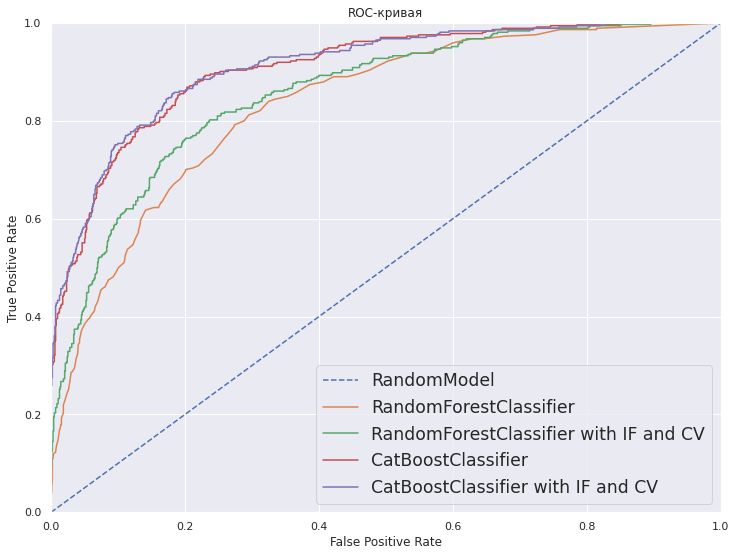

In [71]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = RandomForestClassifier(class_weight = 'balanced', random_state = RANDOM_STATE)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = RandomForestClassifier(**best_params_RFC_2_fi_CV, random_state = RANDOM_STATE)
model.fit(rfc_X_train, target_train)
probabilities_test = model.predict_proba(rfc_X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier with IF and CV',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier with IF and CV')

model = CatBoostClassifier(loss_function = 'CrossEntropy',learning_rate = 0.03, random_state = RANDOM_STATE)
model.fit(train_dataset, plot=False, verbose = False)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC CatBoostClassifier',auc_roc)
plt.plot(fpr, tpr, label='CatBoostClassifier')

model = CatBoostClassifier(**best_params_CB_2_fi_CV, random_state = RANDOM_STATE)
model.fit(CB_2_train_dataset, plot=False, verbose = False)
probabilities_test = model.predict_proba(CB_2_X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC CatBoostClassifier with IF and CV',auc_roc)
plt.plot(fpr, tpr, label='CatBoostClassifier with IF and CV')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Проверю модель на валидационной выборке

In [72]:
valid_dataset = Pool(features_valid, target_valid)
CB_2_X_valid = features_valid[CB_features.index]

CB_2_valid_dataset = Pool(CB_2_X_valid, target_valid)

In [74]:
%%time
valid_CB_2_fi_CV = CatBoostClassifier(**best_params_CB_2_fi_CV, random_state = RANDOM_STATE)
valid_CB_2_fi_CV.fit(CB_2_train_dataset, plot=False, verbose = False)

valid_CB_2_fi_CV_Prediction_Proba = valid_CB_2_fi_CV.predict_proba(CB_2_X_valid)[:,1]
valid_CB_2_fi_CV_Prediction = valid_CB_2_fi_CV.predict(CB_2_X_valid)
valid_CB_2_fi_CV_roc = roc_auc_score(target_valid, valid_CB_2_fi_CV_Prediction_Proba)
valid_CB_2_fi_CV_acc = accuracy_score(target_valid, valid_CB_2_fi_CV_Prediction)
print('valid_CB_2_fi_CV_roc =', valid_CB_2_fi_CV_roc)
print('valid_CB_2_fi_CV_acc =', valid_CB_2_fi_CV_acc)
print('precision =', precision_score(target_valid, valid_CB_2_fi_CV_Prediction))
print('recall =', recall_score(target_valid, valid_CB_2_fi_CV_Prediction))

valid_CB_2_fi_CV_roc = 0.9067800769846805
valid_CB_2_fi_CV_acc = 0.8601845280340668
precision = 0.8
recall = 0.6310160427807486
CPU times: user 1.54 s, sys: 88.4 ms, total: 1.63 s
Wall time: 2.36 s


Модель отлично показала себя и на валидационной выборке - ROC-AUC - 0.9067, Accuracy - 0.8601.

## Отчёт

В ходе работы над проектом придерживался намеченного плана и было выполнено следующее:

1. Внимательно изучил техническое задание на проект, провёл первичный анализ.
2. Полученные данные проанализированны:
- данные загружены;
- в данных выявил недостатки, пути их решения и возможные причины их возникновения;
- все датасеты объединил в один датасет для удобства работы;
- cформулировал соответствующие выводы.

3. По предобработке данных проведены следующие действия:
- поиск дубликатов;
- исправил недостатки в данных, определенных на предыдущем этапе;
- исправлил найденые аномалий.

4. Исследовательский анализ данных:
- ввел новые признаки для анализа, в т.ч. целевой признак Churn, указывающий на статус клиента;
- определил зависимости между различными признаками (провёл графический анализ на мультиколлениарность);
- cформулировал соответствующие выводы.

5. Подготовка данных к расчету модели:
- закодировал категориальные переменные;
- сформировал конечный датасет - были удалены столбцы, которые могли бы вносить "шум" или создавать утёчку в данных;
- сделал выводы.

6. Моделирование:
- данные разделил на три выборки: обучающую, тестовую, валидационную выборки;
- обучил модель RandomForestClassifier с параметром class_weight = 'balanced' для учета дисбаланса целевого признака;
- обучил модель RandomForestClassifier с FI и CV, которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры;
- обучил модель CatBoostClassifier с типичными гиперпараметрами;
- обучил модель CatBoostClassifier с FI и CV, которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры.

7. Тестирование моделей:
- модели протестировална тестовой выборке;
- построил сводную таблицу моделей и полученных метрик;
- построил сводный график Receiver Operating Characteristic (ROC) и вычислил Area Under Curve ROC (AUC ROC);
- все исследованные модели выполнили "минимальную задачу", две модели выполнили "идеальную задачу".
- наилучшей моделью по метрикам auc-roc и accuracy оказалась модель CatBoostClassifier с FI и CV, которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры (auc-roc = 0.9105, accuracy = 0.8594);
- для наилучшей модели произвел проверку на валидационной выборке, значение метрик после проверки выполняют "идеальную задачу"(roc_auc = 0.9067, accuracy = 0.8601).

**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

Выполнены были все пункты плана (что очень радует - не пропустил значимый ход действий при составлении плана)


**Какие трудности возникли и как вы их преодолели?**

Столкнулся с двумя сложностями:
1. Оставил лишний столбец из-за которого происходила утечка данных, благо додумался добавить проверку на мультиколлениарность и столбец с зависимостью был удалён из датасета для обучения модели.
2. Моя невнимательность - обучение и тестирование на одной модели проводил на тестовой выборке, два дня не мог увидеть, благодаря наставнику только обнаружил свою ошибку - неточность ввода.

**Какие ключевые шаги в решении задачи выделили?**

Главным шагом к решению задачи стало четкое выполнение последовательности действий, описанных в плане работы, которые отражают все методы класического обучения.
Ключевыми шагами к получению модели высокого качества стали:
1. Понимание исходных данных.
2. Создание дополнительных признаков и выделение целевого признака.
3. Выделение ключевых признаков, которые наиболее сильно влияют на результат модели.
4. Анализ мультиколлениарности.
5. Динамический подбор гиперпараметров.

**Какая ваша итоговая модель и какое у неё качество?**

Модель CatBoostClassifier с FI и CV, которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры. Её качество определено следующими метриками:

- roc_auc = 0.9067800769846805
- accuracy = 0.8601845280340668
- precision = 0.8
- recall = 0.6310160427807486